## Assignment 1
### Stochastic Simulation

Team:
- Yuxin
- Marcel
- Koen

**Import Libraries**

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from scipy.stats import qmc
from scipy.stats.qmc import LatinHypercube
from concurrent.futures import ThreadPoolExecutor
from scipy.stats import linregress

# For output push
import subprocess
from datetime import datetime

---
## 1. Implementing and Visualizing Different Sampling Techniques

- Define the function that let's us randomly sample in three different ways:
    - Pure Random Sampling
    - Latin Hypercube Sampling
    - Orthogonal Sampling
- Define the funciton that determines whether a complex number is part of the Mandelbrot set or not, using predetrmined finite amount of iteration

In [2]:
# Define Mandelbrot set calculation function
def mandelbrot(point: complex, max_iter: int =1000) -> int:
    z = 0
    for i in range(max_iter):
        z = z**2 + point
        if abs(z) > 2:
            return i
    return max_iter

In [3]:
# Define the random sampling function
def random_sample(n: int, x_range: tuple, y_range: tuple, sampler: str ='pure_random_sampling') -> np.ndarray:
    match sampler:
        case 'pure_random_sampling':
            # Pure random sampling
            x_coords = np.random.uniform(x_range[0], x_range[1], n)
            y_coords = np.random.uniform(y_range[0], y_range[1], n)
            points = np.stack((x_coords, y_coords), axis=-1)

        case 'latin_hypercube_sampling':
            # Latin Hypercube Sampling
            lhc = qmc.LatinHypercube(d=2)
            points = lhc.random(n)
            points[:, 0] = points[:, 0] * (x_range[1] - x_range[0]) + x_range[0]
            points[:, 1] = points[:, 1] * (y_range[1] - y_range[0]) + y_range[0]

        case 'orthogonal_sampling':
            n_bucket = int(np.sqrt(n))
            if np.power(n_bucket, 2) != n:
                raise ValueError('"n" must be a perfect square')

            x_coord = np.linspace(x_range[0], x_range[1], n_bucket, endpoint=False)
            y_coord = np.linspace(y_range[0], y_range[1], n_bucket, endpoint=False)

            xv, yv = np.meshgrid(x_coord, y_coord)
            points = np.column_stack((xv.ravel(), yv.ravel()))

            x_random = (x_range[1] - x_range[0]) / n_bucket * np.random.rand(n)
            y_random = (y_range[1] - y_range[0]) / n_bucket * np.random.rand(n)

            points[:, 0] += x_random
            points[:, 1] += y_random
            
        case _:
            raise ValueError("Invalid sampler specified.")
    
    return np.array([complex(point[0], point[1]) for point in points])


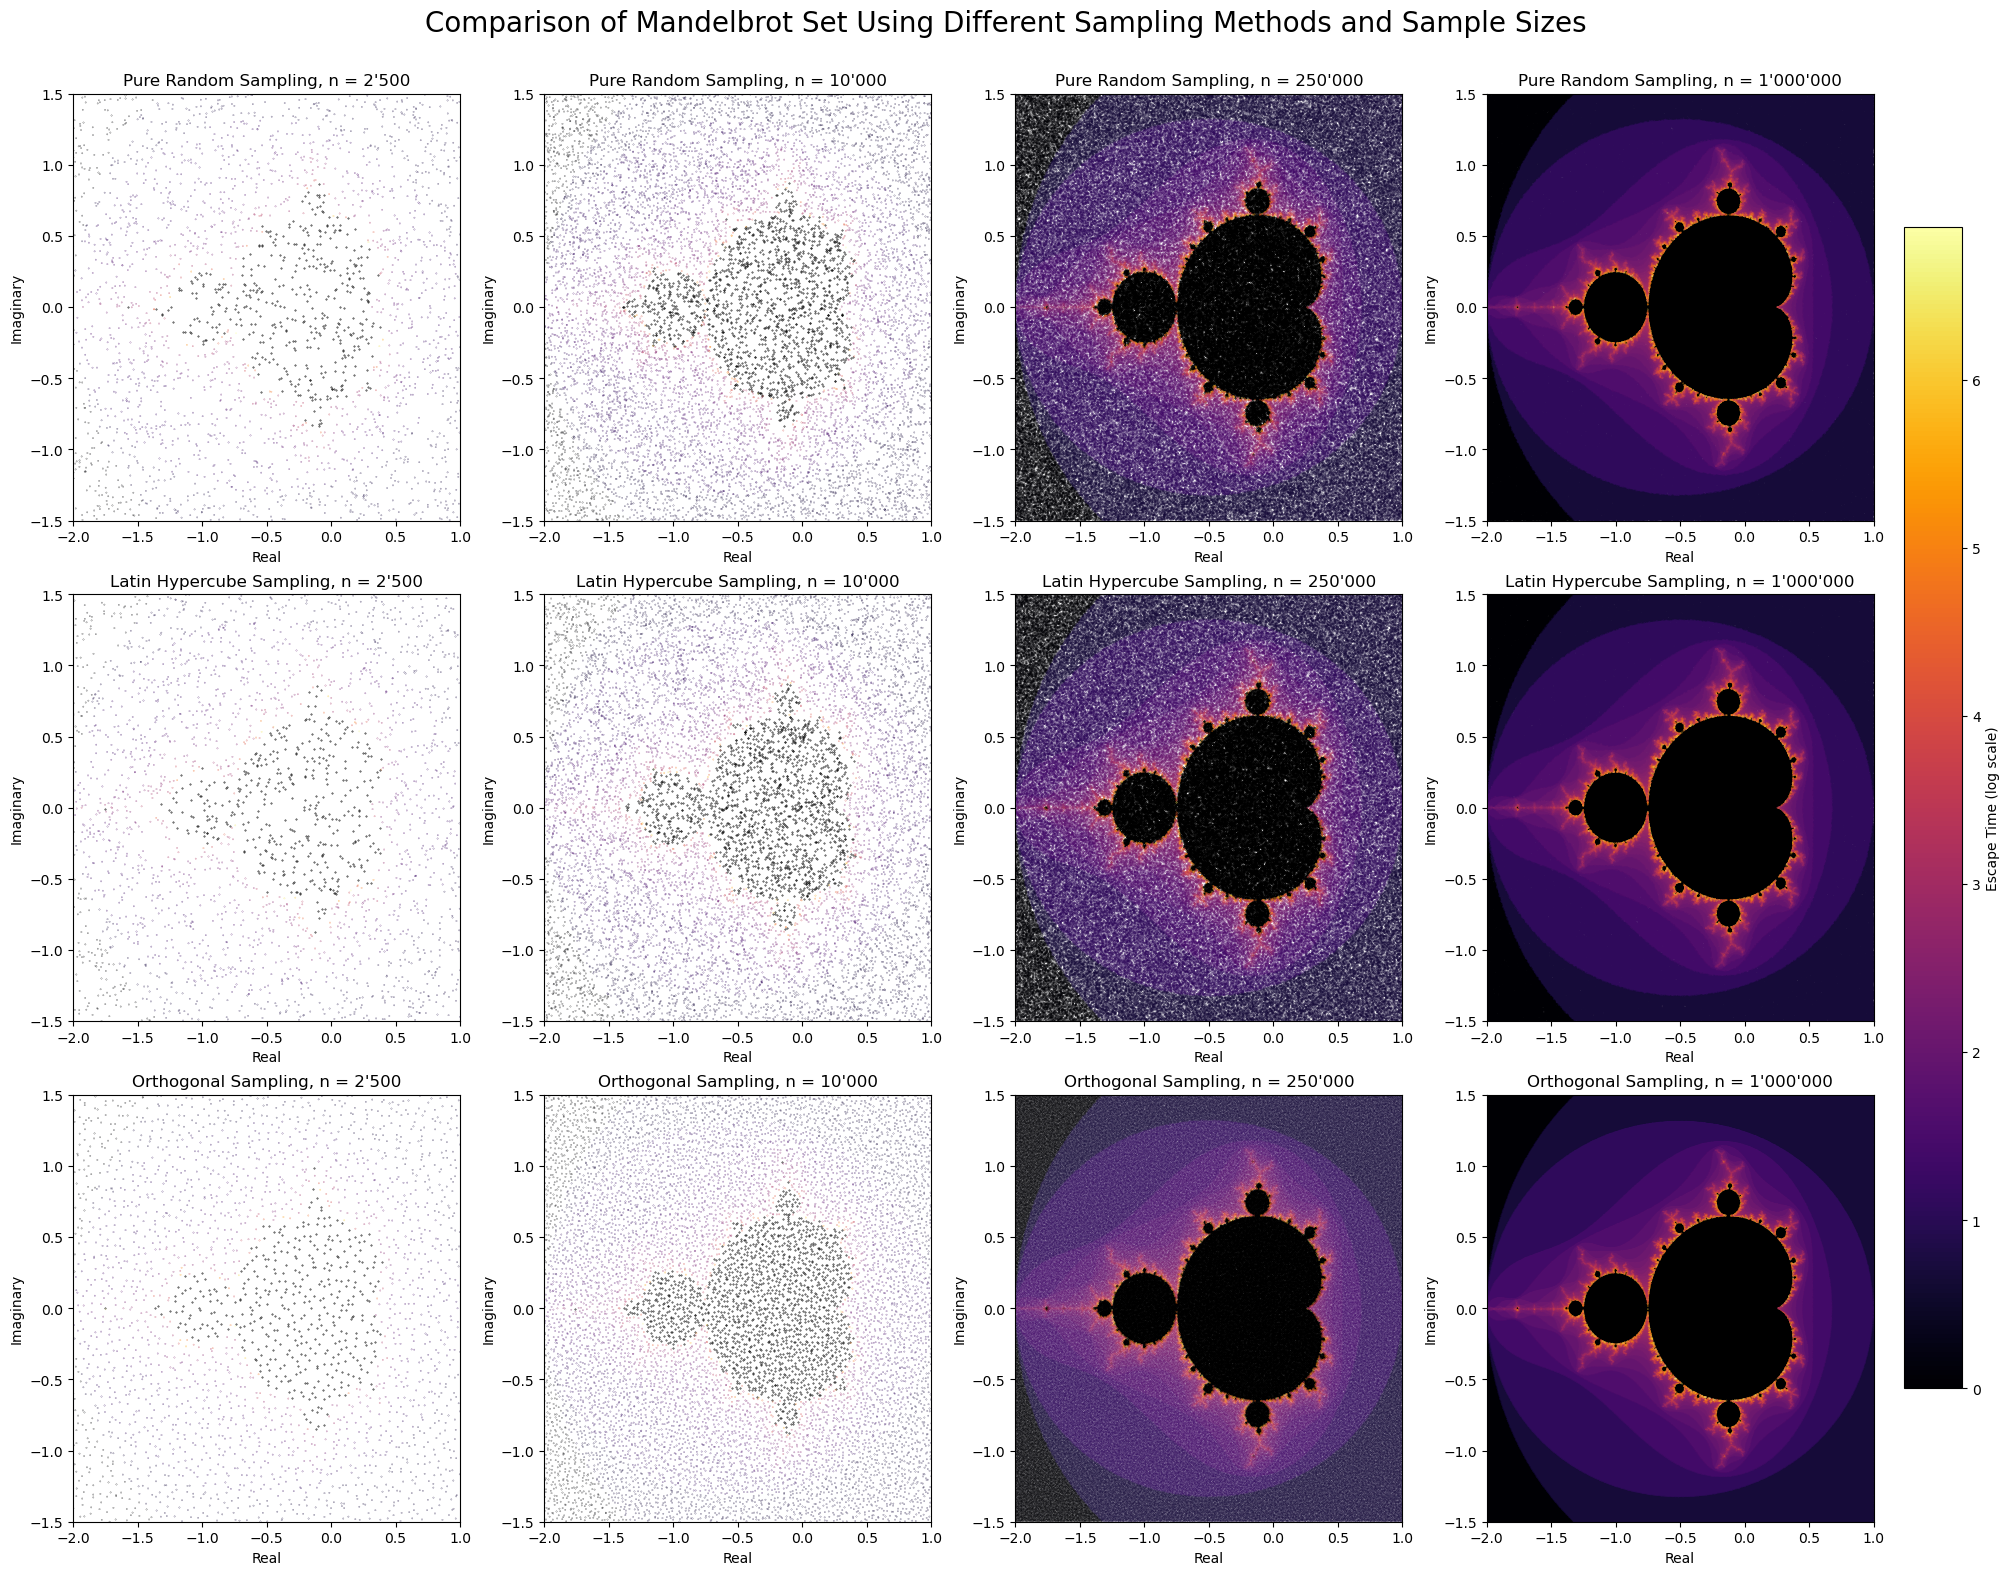

In [4]:
# Plotting the different types of sampling techniques for different sample size
def plot_mandelbrot_subfig(n=10000, x_range=(-2, 1), y_range=(-1.5, 1.5), max_iter=1000, sampler='pure_random_sampling', ax=None):
    sample = random_sample(n, x_range, y_range, sampler)
    iterations = np.array([mandelbrot(point, max_iter) for point in sample])

    # Separate points inside and outside the Mandelbrot set
    in_set = iterations == max_iter
    outside_set = ~in_set

    # Use log-scaled colors for points outside the set
    colors = np.log(iterations + 1)

    # Plot on the provided axis
    ax.scatter(sample[in_set].real, sample[in_set].imag, color='black', s=0.5, marker='.')
    scatter = ax.scatter(sample[outside_set].real, sample[outside_set].imag,
                         c=colors[outside_set], cmap='inferno', s=0.1, marker='.')

    # Set plot details
    ax.set_xlim(x_range)
    ax.set_ylim(y_range)

    sample_title = f"n = {n:,}".replace(',', "'")
    if n % 10 != 0:
        sample_title = f"n ≈ {int(int(n / 100) * 100):,}".replace(',', "'")
    ax.set_title(f"{sampler.replace('_', ' ').title()}, {sample_title}")
    ax.set_xlabel("Real")
    ax.set_ylabel("Imaginary")
    return scatter

# Set up the subplots for comparing different sampling methods and sample sizes
fig, axes = plt.subplots(3, 4, figsize=(20, 15), constrained_layout=True)
fig.suptitle("Comparison of Mandelbrot Set Using Different Sampling Methods and Sample Sizes", fontsize=20, y=1.04)

# Define parameters
samplers = ['pure_random_sampling', 'latin_hypercube_sampling', 'orthogonal_sampling']
sample_sizes = [2500, 10000, 250000, 1000000]

# Plot for each sampler and sample size
for row, sampler in enumerate(samplers):
    for col, n in enumerate(sample_sizes):
        ax = axes[row, col]
        scatter = plot_mandelbrot_subfig(n, x_range=(-2, 1), y_range=(-1.5, 1.5), max_iter=1000, sampler=sampler, ax=ax)
        print(f"check n = {n} done")
    print(f"check sampler = {sampler} done")

# Add a color bar to the last axis for escaping points
fig.colorbar(scatter, ax=axes[:, -1], orientation='vertical', label="Escape Time (log scale)")

clear_output(wait=True)
# plt.savefig(os.path.join(lib_task_3, "mandelbrot_pic_with_diff_sampling.png"), dpi=500)
plt.show()

---
## 2. Estimating the Mandelbrot Set Area and Accuracy

 - Using the sampling methods implemented in Part 1, we perform Monte Carlo integration to estimate the area of the Mandelbrot set, denoted by  $A_M$ .
 - Each sampling method generates an estimate  $A_{i,s}$ , where  $i$  is the number of iterations, and  $s$  is the sample size.
 - The accuracy of each method is calculated by comparing the estimated area  $A_{i,s}$  to the true area  $A_M$ , and the mean relative error is reported to evaluate each method’s accuracy.

In [5]:
# Pure Random Sampling
def monte_carlo_area_estimation(s: int, j: int, x_range: tuple, y_range: tuple, sampler: str) -> float:
    sample = random_sample(s, x_range, y_range, sampler)
    in_set_counter = np.sum([is_in_mandelbrot(number, j) for number in sample])
    return (in_set_counter / len(sample)) * (x_range[1] - x_range[0]) *(y_range[1] - y_range[0])


# Calculate the integral estimation for different iteration numbers smaller than the max iteration number
def calc_effect_of_number_iter(s: int, j_max: int, x_range: tuple, y_range: tuple, sampler: str, k: int = 100, start_j: int = 1) -> np.ndarray:
    if start_j * 0.5 > j_max:
        raise ValueError("Starting iteration number is too high.")
    iter_numbers = np.arange(start_j, j_max + k, k)
    area_estimations = np.array([monte_carlo_area_estimation(s, actual_iter, x_range, y_range, sampler) for actual_iter in iter_numbers])
    return iter_numbers, area_estimations


# Calculate the integral estimation for different sample sizes
def calc_effect_of_sample_size(s_max: int, j: int, x_range: tuple, y_range: tuple, sampler: str, k: int, start_s: int) -> np.ndarray:
    if start_s * 0.5 > s_max:
        raise ValueError("Starting sample size is too high.")
    sample_sizes = np.arange(start_s, s_max + k, k)
    area_estimations = np.array([monte_carlo_area_estimation(actual_sample_size, j, x_range, y_range, sampler) for actual_sample_size in sample_sizes])
    return sample_sizes, area_estimations


# Support functions
def is_in_mandelbrot(number: complex, iter_num: int) -> bool:
    return mandelbrot(number, iter_num) == iter_num

In [6]:
# Parameters
s = 10000  # Sample size
j = 1000
x_range = (-2, 0.5)
y_range = (-1.25, 1.25)
true_area = 1.50659177  # Known area of the Mandelbrot set (for accuracy calculation)

# Monte Carlo area estimation using different sampling methods
area_random = monte_carlo_area_estimation(s, j, x_range, y_range, "pure_random_sampling")
area_lhs = monte_carlo_area_estimation(s, j, x_range, y_range, "latin_hypercube_sampling")
area_orthogonal = monte_carlo_area_estimation(s, j, x_range, y_range, "orthogonal_sampling")

# Print estimated areas
print("Estimated area using Pure Random Sampling:", area_random)
print("Estimated area using Latin Hypercube Sampling:", area_lhs)
print("Estimated area using Orthogonal Sampling:", area_orthogonal)

# Calculate relative accuracy (relative error) for each method
relative_error_random = np.abs((area_random - true_area) / true_area)
relative_error_lhs = np.abs((area_lhs - true_area) / true_area)
relative_error_orthogonal = np.abs((area_orthogonal - true_area) / true_area)

# Calculate absolute accuracy (absolute error) for each method
absolute_error_random = np.abs(area_random - true_area)
absolute_error_lhs = np.abs(area_lhs - true_area)
absolute_error_orthogonal = np.abs(area_orthogonal - true_area)

# Print accuracy results
print("Relative Error using Pure Random Sampling:", relative_error_random)
print("Relative Error using Latin Hypercube Sampling:", relative_error_lhs)
print("Relative Error using Orthogonal Sampling:", relative_error_orthogonal)

print("Absolute Error using Pure Random Sampling:", absolute_error_random)
print("Absolute Error using Latin Hypercube Sampling:", absolute_error_lhs)
print("Absolute Error using Orthogonal Sampling:", absolute_error_orthogonal)

Estimated area using Pure Random Sampling: 1.501875
Estimated area using Latin Hypercube Sampling: 1.5231249999999998
Estimated area using Orthogonal Sampling: 1.5175
Relative Error using Pure Random Sampling: 0.003130755187916582
Relative Error using Latin Hypercube Sampling: 0.010973928259278785
Relative Error using Orthogonal Sampling: 0.007240335582080124
Absolute Error using Pure Random Sampling: 0.004716769999999926
Absolute Error using Latin Hypercube Sampling: 0.016533229999999843
Absolute Error using Orthogonal Sampling: 0.010908230000000074


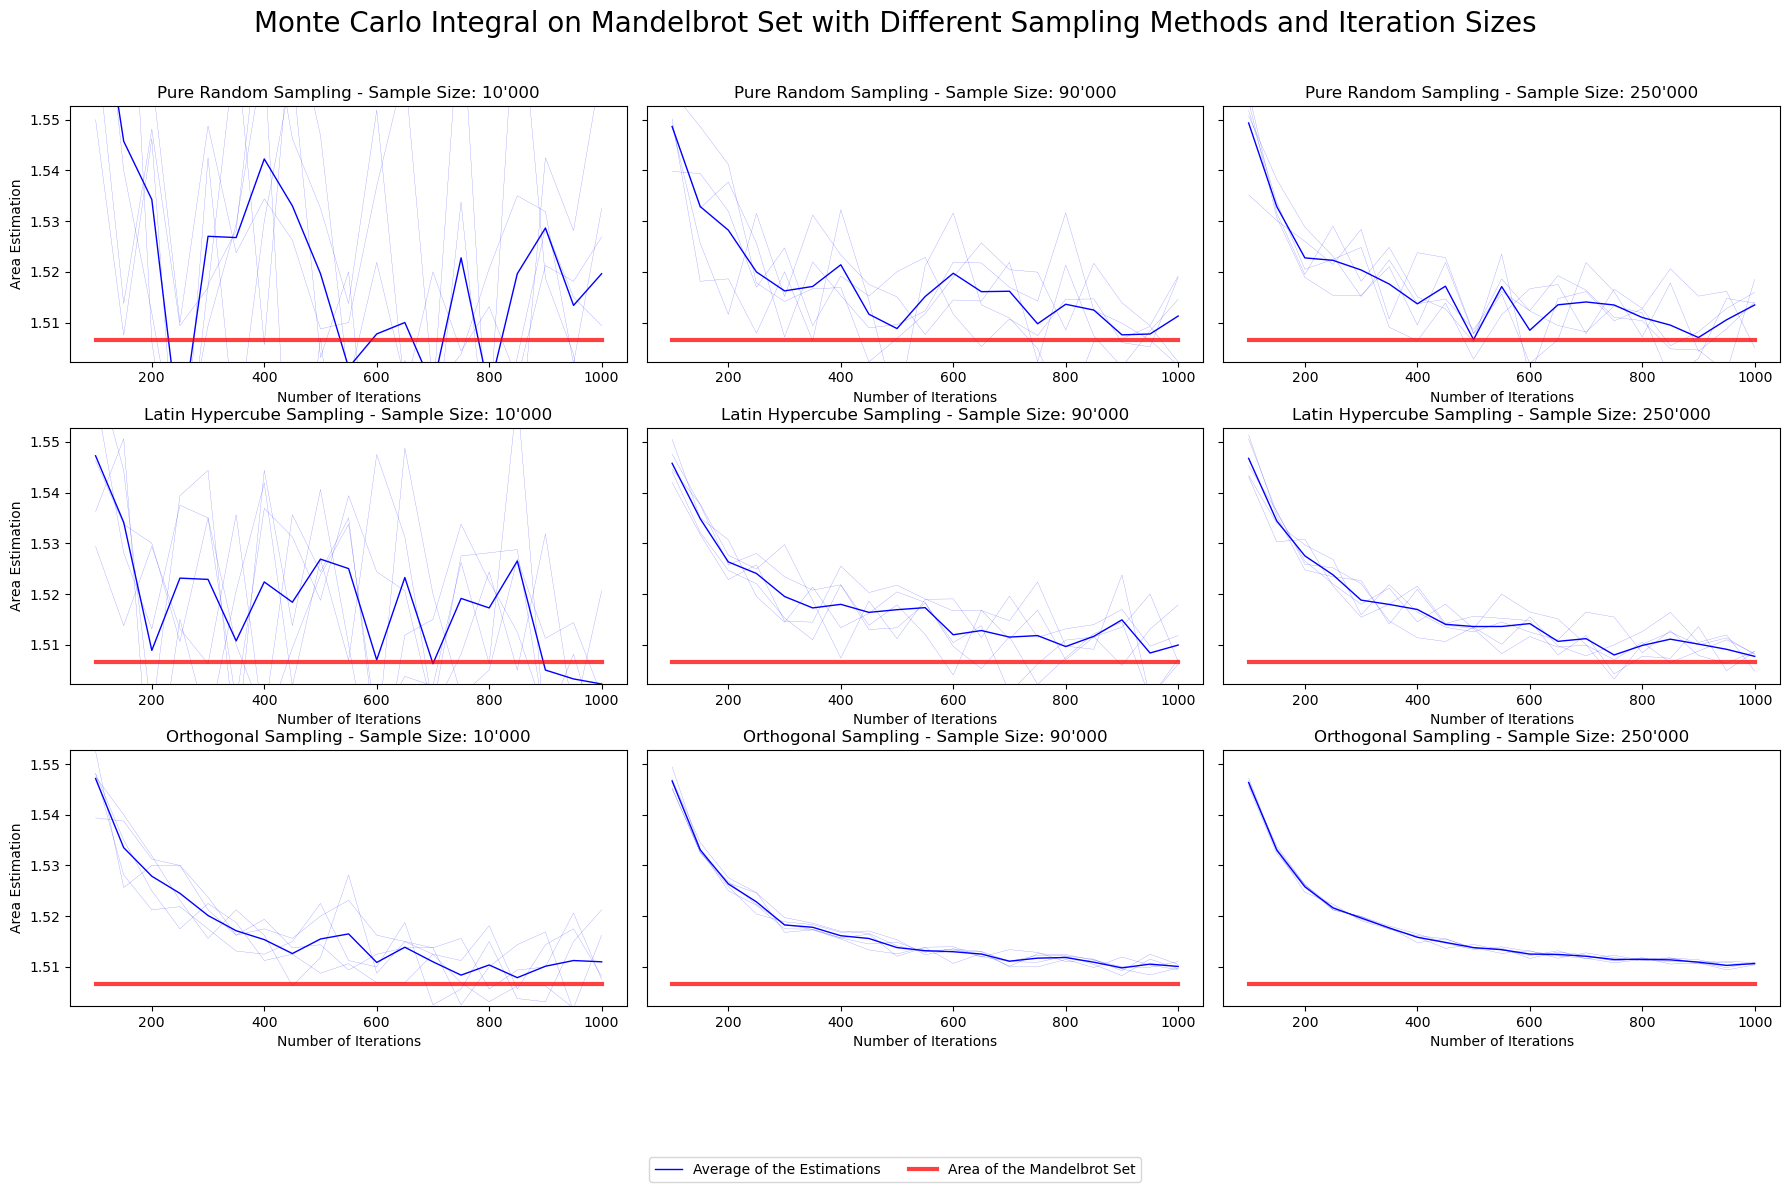

In [7]:
# Parameters
max_iter = 1000
stepsize = 50
start_iter_n = 100
x_range = (-2, 0.5)
y_range = (-1.25, 1.25)
n_estimation_run = 5
true_area = 1.50659177
sample_sizes = [10000, 90000, 250000]
samplers = ['pure_random_sampling', 'latin_hypercube_sampling', 'orthogonal_sampling']

# Set up the figure with 3 rows for samplers (including pure random)
fig, axes = plt.subplots(len(samplers), 3, figsize=(18, 12), sharey=True)

# If there is only one row, make axes a 2D array for consistency
if len(samplers) == 1:
    axes = np.expand_dims(axes, axis=0)

# Initialize true_line for the reference legend line
true_line = None

for row, sampler in enumerate(samplers):
    # Initialize avg_line for each sampler
    avg_line = None

    # Determine the min and max y-values for consistent scaling across subplots
    _, area_estimations = calc_effect_of_number_iter(sample_sizes[0], max_iter, x_range, y_range, sampler, stepsize, start_iter_n)
    y_min, y_max = min(area_estimations), max(area_estimations)

    for col, sample_size in enumerate(sample_sizes):
        ax = axes[row, col]  # Access the correct subplot

        # Get area estimations for the current sample size and sampler
        _, area_estimations = calc_effect_of_number_iter(sample_size, max_iter, x_range, y_range, sampler, stepsize, start_iter_n)
        subplot_y_min, subplot_y_max = min(area_estimations), max(area_estimations)

        # Update global y-axis limits for uniform scaling across subplots
        y_min = min(y_min, subplot_y_min)
        y_max = max(y_max, subplot_y_max)

        # Add a buffer to y-limits for better visualization
        buffer = 0.01 * (y_max - y_min)
        y_min -= buffer
        y_max += buffer

        # Run multiple estimations and plot each individual run
        avg_area = []
        for _ in range(n_estimation_run):
            iter_numbers, area_estimations = calc_effect_of_number_iter(sample_size, max_iter, x_range, y_range, sampler, stepsize, start_iter_n)
            ax.plot(iter_numbers, area_estimations, color="blue", linewidth=0.2, alpha=0.5)
            avg_area.append(area_estimations)

        # Plot the average of all runs
        avg_area = np.average(np.array(avg_area), axis=0)
        if avg_line is None:
            avg_line, = ax.plot(iter_numbers, avg_area, color="blue", linewidth=1, label="Average of the Estimations")
        else:
            ax.plot(iter_numbers, avg_area, color="blue", linewidth=1)

        # Plot the true area as a reference line
        if true_line is None:
            true_line, = ax.plot(iter_numbers, true_area * np.ones_like(iter_numbers), color="red", linewidth=3, alpha=0.75, label="Area of the Mandelbrot Set")
        else:
            ax.plot(iter_numbers, true_area * np.ones_like(iter_numbers), color="red", linewidth=3, alpha=0.75)

        # Titles and labels
        ax.set_title(f"{sampler.replace('_', ' ').title()} - Sample Size: {sample_size:,}".replace(",", "'"))
        ax.set_xlabel("Number of Iterations")
        if col == 0:
            ax.set_ylabel("Area Estimation")

        # Set consistent y-axis limits with buffer
        ax.set_ylim(y_min, y_max)

# Overall title and legend
fig.suptitle("Monte Carlo Integral on Mandelbrot Set with Different Sampling Methods and Iteration Sizes", fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=0.9, bottom=0.15)

# Add a single legend at the bottom
fig.legend([avg_line, true_line], ["Average of the Estimations", "Area of the Mandelbrot Set"], loc='lower center', ncol=2, frameon=True)

# Show plot
plt.show()

---
## 3. Calculating and Comparing Convergence Rates

 - Investigate the convergence behavior of each sampling technique as both the sample size  $s$  and iteration count  $i$  increase.
 - For each method, we calculate the error between the estimated area and the true area, plotting the convergence rate on a log-log scale.
 - This provides insight into how quickly each method converges to the true area and allows us to identify the most efficient sampling method among the three.

Sampler: Pure Random Sampling, Iteration: 100
Convergence rate: -0.0405
Accuracy (Mean Relative Error): 0.0278
----------------------------------------
Sampler: Pure Random Sampling, Iteration: 500
Convergence rate: -0.1024
Accuracy (Mean Relative Error): 0.0065
----------------------------------------
Sampler: Pure Random Sampling, Iteration: 1000
Convergence rate: -0.2222
Accuracy (Mean Relative Error): 0.0045
----------------------------------------
Sampler: Latin Hypercube Sampling, Iteration: 100
Convergence rate: -0.0077
Accuracy (Mean Relative Error): 0.0266
----------------------------------------
Sampler: Latin Hypercube Sampling, Iteration: 500
Convergence rate: -0.0528
Accuracy (Mean Relative Error): 0.0058
----------------------------------------
Sampler: Latin Hypercube Sampling, Iteration: 1000
Convergence rate: -0.4738
Accuracy (Mean Relative Error): 0.0046
----------------------------------------
Sampler: Orthogonal Sampling, Iteration: 100
Convergence rate: -0.0122
Acc

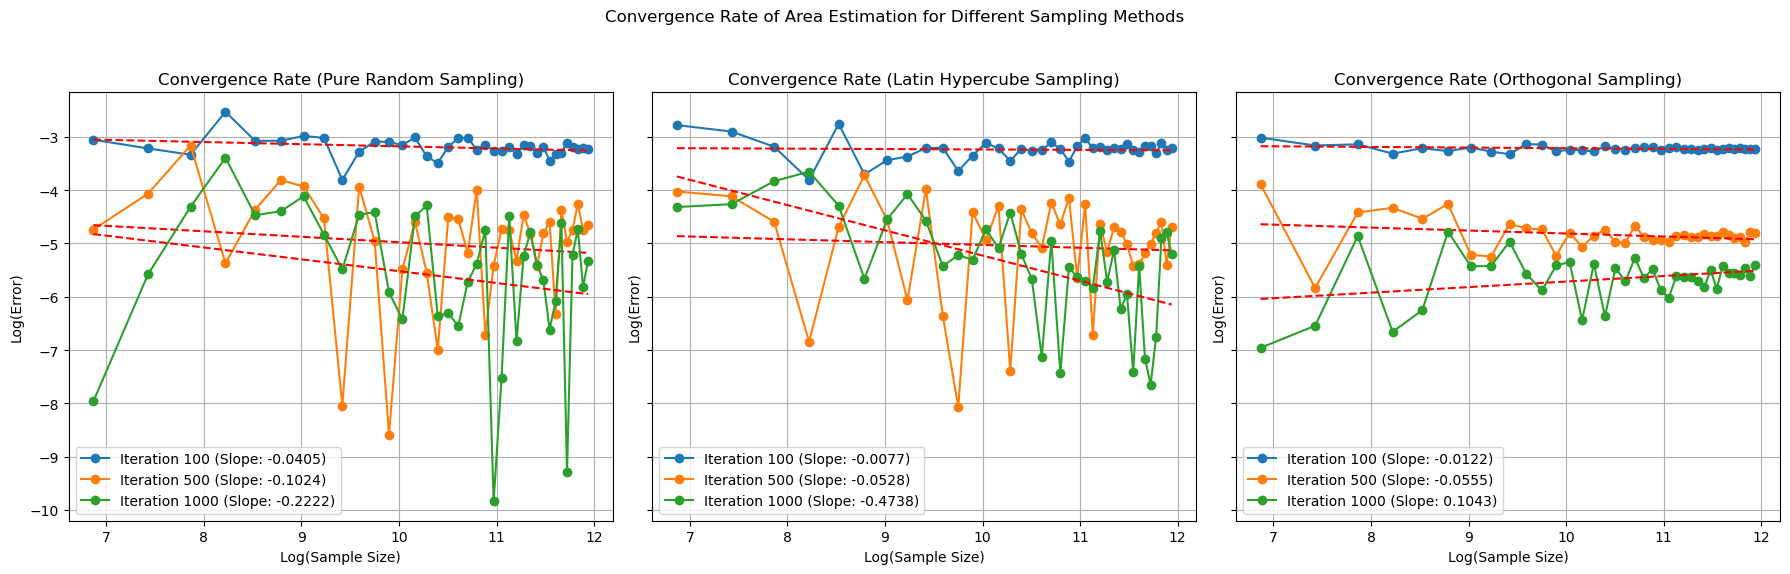

In [17]:
# Parameters
max_sample_size = 160000  # Maximum sample size as a perfect square limit
j = 1000
start_sample_size = 1000
true_area = 1.50659177
n_estimation_run = 5

# Sample sizes as perfect squares up to max_sample_size
sample_sizes = [i**2 for i in range(int(np.sqrt(start_sample_size)), int(np.sqrt(max_sample_size)) + 1, 10)]
iterations_list = [100, 500, 1000]  # Different iterations for convergence analysis

# Function to calculate Monte Carlo area estimation (simplified)
def monte_carlo_area_estimation(s: int, j: int, x_range: tuple, y_range: tuple, sampler: str) -> float:
    sample = random_sample(s, x_range, y_range, sampler)
    in_set_counter = np.sum([is_in_mandelbrot(number, j) for number in sample])
    return (in_set_counter / len(sample)) * (x_range[1] - x_range[0]) * (y_range[1] - y_range[0])

# Function to run a single estimation for a specific sampler and iteration count
def single_run(s, iteration, sampler):
    area_estimations = []
    for size in sample_sizes:
        area = monte_carlo_area_estimation(size, iteration, x_range, y_range, sampler)
        area_estimations.append(area)
    return area_estimations

# Calculate and plot convergence rate and accuracy for each sampler
def plot_all_convergence_rates():
    fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

    # Loop through each sampling method and create a subplot
    samplers = ['pure_random_sampling', 'latin_hypercube_sampling', 'orthogonal_sampling']
    for idx, sampler in enumerate(samplers):
        all_avg_runs = []

        # Calculate estimations for each iteration count
        for iteration in iterations_list:
            avg_runs = []
            
            # Use ThreadPoolExecutor to calculate multiple runs in parallel
            with ThreadPoolExecutor() as executor:
                results = list(executor.map(lambda _: single_run(sample_sizes, iteration, sampler), range(n_estimation_run)))

            # Calculate the average across multiple runs
            avg_runs = np.average(np.array(results), axis=0)
            all_avg_runs.append(avg_runs)

            # Calculate errors for convergence analysis
            errors = np.abs(avg_runs - true_area)
            log_sample_sizes = np.log(sample_sizes)
            log_errors = np.log(errors)

            # Linear fit on log-log scale to determine convergence rate
            slope, intercept, r_value, p_value, std_err = linregress(log_sample_sizes, log_errors)
            convergence_rate = slope

            # Calculate mean relative error for accuracy
            relative_errors = np.abs((avg_runs - true_area) / true_area)
            mean_relative_error = np.mean(relative_errors)

            # Plot convergence rate in the corresponding subplot
            axs[idx].plot(log_sample_sizes, log_errors, 'o-', label=f"Iteration {iteration} (Slope: {slope:.4f})")
            axs[idx].plot(log_sample_sizes, slope * log_sample_sizes + intercept, 'r--')

            print(f"Sampler: {sampler.replace('_', ' ').title()}, Iteration: {iteration}")
            print(f"Convergence rate: {convergence_rate:.4f}")
            print(f"Accuracy (Mean Relative Error): {mean_relative_error:.4f}")
            print("-"*40)
            
        # Configure subplot settings
        axs[idx].set_title(f"Convergence Rate ({sampler.replace('_', ' ').title()})")
        axs[idx].set_xlabel("Log(Sample Size)")
        axs[idx].set_ylabel("Log(Error)")
        axs[idx].legend()
        axs[idx].grid(True)

    plt.suptitle("Convergence Rate of Area Estimation for Different Sampling Methods")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Run convergence rate analysis and plot for all sampling methods
plot_all_convergence_rates()

---
## 4. Estimation Improvement

- Formulate and test a method to improve the convergence rate of the Monte Carlo approach
- Examine the convergence pace and the accuracy of the new estimator algorithm compared to the previous ones

---
## PS Push output to Repository

In [4]:
# Define the output directory in your repository
output_dir = "output"
os.makedirs(output_dir, exist_ok=True)  # Create the folder if it doesn't exist

# Step 1: Save All Plots to Output Folder
# Example: Save a plot to the output folder with a timestamp
def save_plot(filename):
    plt.savefig(os.path.join(output_dir, filename))

# Add code like this after each plot to save with a unique filename
# Example: save_plot(f"plot_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png")

# Step 2: Push All Files in Output Folder to GitHub
def push_all_images_to_github():
    try:
        # Add all images in the output folder
        subprocess.run(["git", "add", f"{output_dir}"], check=True)
        
        # Commit with a message including the current timestamp
        commit_message = f"Add all plots to output folder - {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}"
        subprocess.run(["git", "commit", "-m", commit_message], check=True)
        
        # Push to GitHub
        subprocess.run(["git", "push"], check=True)
        print("All images have been committed and pushed to GitHub.")
        
    except subprocess.CalledProcessError as e:
        print(f"An error occurred: {e}")

# Call this function at the end of your notebook to push all images
push_all_images_to_github()

On branch main
Your branch is up to date with 'origin/main'.

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	ReorganizedCode.ipynb

nothing added to commit but untracked files present (use "git add" to track)
An error occurred: Command '['git', 'commit', '-m', 'Add all plots to output folder - 2024-11-14 22:29:36']' returned non-zero exit status 1.
